In [1]:
%matplotlib inline

### usual imports

In [2]:
import os
import sys
from glob import glob 

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

### statsmodels 

In [4]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

### fbprophet 

In [5]:
from fbprophet import Prophet

In [6]:
from sklearn.metrics import mean_absolute_error as MAE

### 1st example: cycling counts over Tamaki drive 

In [7]:
lfiles = glob('../data/cycling_Auckland/cycling_counts_????.csv')

In [8]:
lfiles.sort()

In [9]:
lfiles

['../data/cycling_Auckland/cycling_counts_2010.csv',
 '../data/cycling_Auckland/cycling_counts_2011.csv',
 '../data/cycling_Auckland/cycling_counts_2012.csv',
 '../data/cycling_Auckland/cycling_counts_2013.csv',
 '../data/cycling_Auckland/cycling_counts_2014.csv',
 '../data/cycling_Auckland/cycling_counts_2015.csv',
 '../data/cycling_Auckland/cycling_counts_2016.csv',
 '../data/cycling_Auckland/cycling_counts_2017.csv',
 '../data/cycling_Auckland/cycling_counts_2018.csv']

In [10]:
l = []
for f in lfiles: 
    d = pd.read_csv(f, index_col=0, parse_dates=True, usecols=['datetime', 'Tamaki Drive EB','Tamaki Drive WB'])
    l.append(d)

In [11]:
df = pd.concat(l, axis=0)

In [12]:
df.head()

In [13]:
df.tail()

In [14]:
df = df.loc[:'2017',:]

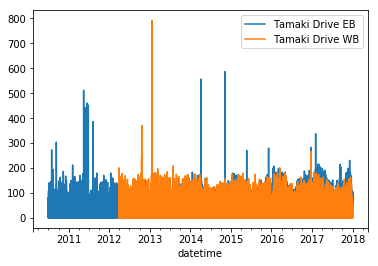

In [15]:
df.plot()

In [16]:
df.dropna(inplace=True)

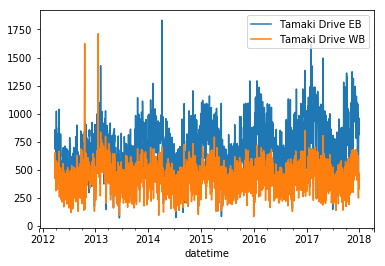

In [17]:
df.resample('1D').sum().plot()

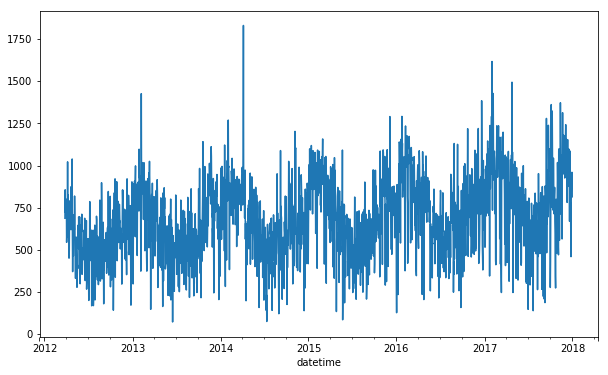

In [18]:
df.resample('1D').sum()['Tamaki Drive EB'].plot(figsize=(10, 6))

### seasonal cycle

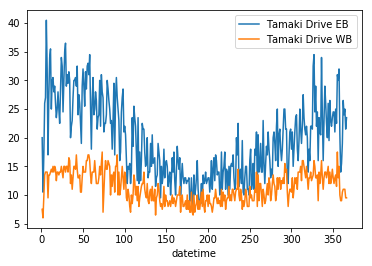

In [19]:
df.groupby(df.index.dayofyear).median().plot()

### weekly cycle

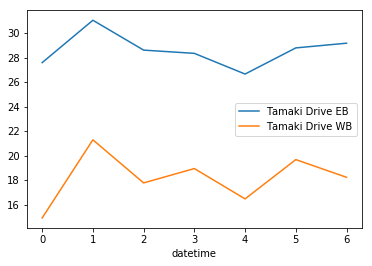

In [20]:
df.groupby(df.index.dayofweek).mean().plot()

### daily cycle 

In [21]:
summary_hour = df.groupby(df.index.hour).describe()

In [22]:
summary_hour.head()

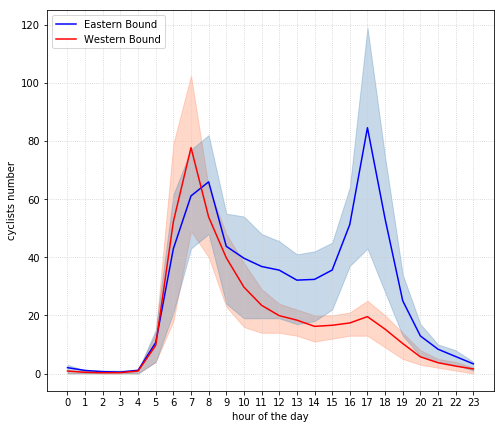

In [23]:

f, ax = plt.subplots(figsize=(8,7))

ax.plot(summary_hour.index, summary_hour.loc[:,('Tamaki Drive EB','mean')], color='b', label='Eastern Bound')
ax.plot(summary_hour.index, summary_hour.loc[:,('Tamaki Drive WB','mean')], color='r', label='Western Bound')

ax.fill_between(summary_hour.index, summary_hour.loc[:,('Tamaki Drive WB','25%')], \
                summary_hour.loc[:,('Tamaki Drive WB','75%')], color='coral', alpha=0.3)

ax.fill_between(summary_hour.index, summary_hour.loc[:,('Tamaki Drive EB','25%')], \
                summary_hour.loc[:,('Tamaki Drive EB','75%')], color='steelblue', alpha=0.3)

ax.legend(loc=2)

ax.set_xticks(range(24));
ax.grid(ls=':', color='0.8')

ax.set_xlabel('hour of the day')

ax.set_ylabel('cyclists number');

### resampling at the daily time-step


In [24]:
df = df.resample('1D').sum()

In [25]:
df.head()

In [26]:
df.tail()

In [27]:
decomposition = seasonal_decompose(df.loc[:,'Tamaki Drive EB'], freq=365) 

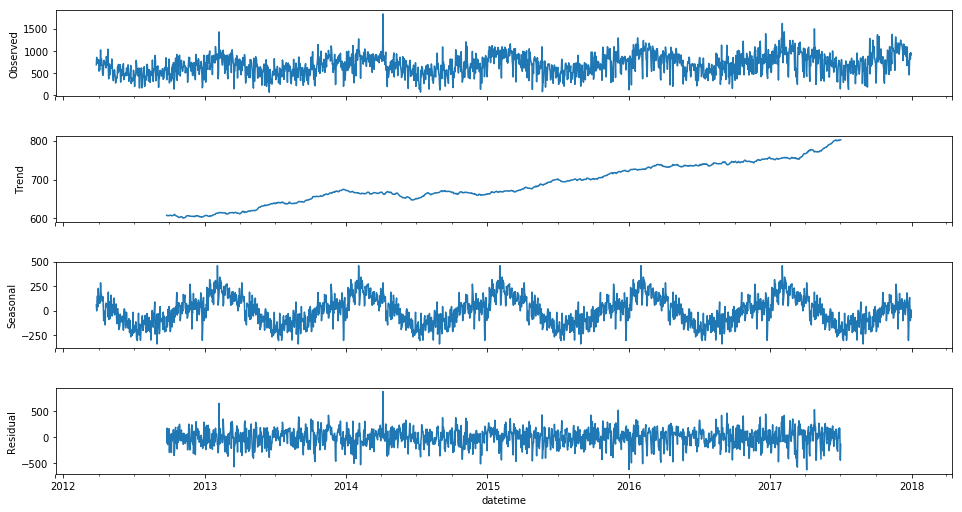

In [28]:
f = decomposition.plot() 
f.set_size_inches(15, 8)

In [29]:
data = df.loc[:,['Tamaki Drive EB']]

In [30]:
data = data.rename({'Tamaki Drive EB':'y'}, axis=1)

In [31]:
data.tail()

In [32]:
def add_regressor(data, regressor, varname=None): 
    
    data.loc[:,varname] = regressor.loc[:,varname]
    
    return data

In [33]:
def prepare_data(data, year): 
    
    data_train = data.loc[:str(year - 1),:]
    
    data_test = data.loc[str(year):,:]
    
    data_train.reset_index(inplace=True)
    
    data_test.reset_index(inplace=True)
    
    data_train = data_train.rename({'datetime':'ds'}, axis=1)
    
    data_test = data_test.rename({'datetime':'ds'}, axis=1)
    
    return data_train, data_test

In [34]:
def make_verif(forecast, data_train, data_test): 
    
    forecast.index = pd.to_datetime(forecast.ds)
    
    data_train.index = pd.to_datetime(data_train.ds)
    
    data_test.index = pd.to_datetime(data_test.ds)
    
    data = pd.concat([data_train, data_test], axis=0)
    
    forecast.loc[:,'y'] = data.loc[:,'y']
    
    return forecast

In [35]:
def plot_verif(verif, year=2017): 
    
    f, ax = plt.subplots(figsize=(10, 8))
    
    train = verif.loc[:str(year - 1),:]
    
    ax.plot(train.index, train.y, 'ko', markersize=3)
    
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
    test = verif.loc[str(year):,:]
    
    ax.plot(test.index, test.y, 'ro', markersize=3)
    
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    
    ax.axvline(str(year), color='0.8', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)

In [36]:
def add_regressor_to_future(future, regressors_list): 
    
    futures = future.copy() 
    
    futures.index = pd.to_datetime(futures.ds)
    
    regressors = pd.concat(regressors_list, axis=1)
    
    futures = futures.merge(regressors, left_index=True, right_index=True)
    
    futures = futures.reset_index(drop = True) 
    
    return futures

In [37]:
data_train, data_test = prepare_data(data, 2017)

In [38]:
m = Prophet(mcmc_samples=300, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [39]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


In [40]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [41]:
forecast = m.predict(future)

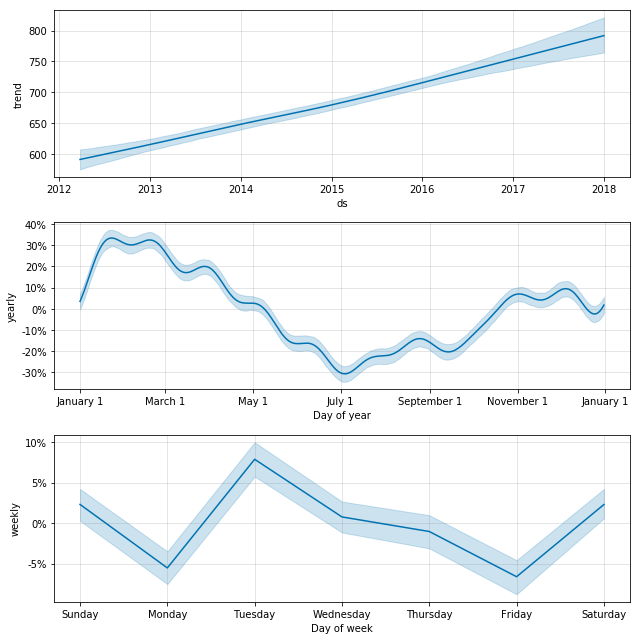

In [42]:
f = m.plot_components(forecast)

In [43]:
verif = make_verif(forecast, data_train, data_test)

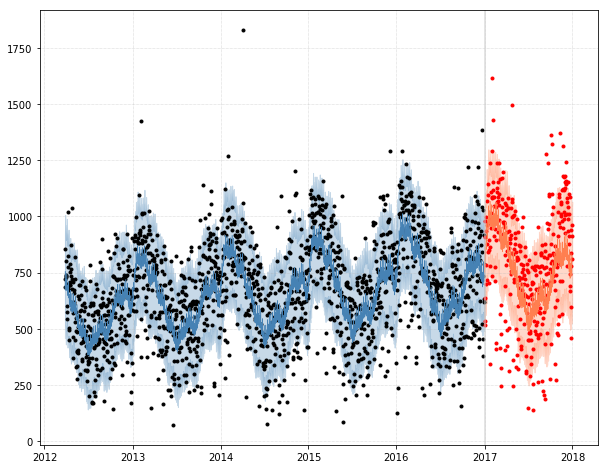

In [44]:
plot_verif(verif)

In [45]:
verif.loc[:,['y','yhat']].corr()

In [46]:
verif.loc[:'2017',['y','yhat']].corr()

In [47]:
MAE(verif.y.values, verif.yhat.values)

143.08652270587152

### modelling the effects of the holidays 

In [48]:
holidays_calendar = pd.read_csv('../data/holidays_calendars_2011_2018.csv')

In [49]:
holidays_calendar.loc[:,'ISO_date'] = pd.to_datetime(holidays_calendar.loc[:,'ISO_date'], dayfirst=True)

In [50]:
holidays_calendar = holidays_calendar.dropna(axis=1, how='all').dropna(axis=0, how='all')

In [51]:
holidays_calendar = holidays_calendar.loc[-holidays_calendar.notes.str.contains('Not a public'),:]

In [52]:
holidays = holidays_calendar.loc[(holidays_calendar.loc[:,'Regional'] == 0) | holidays_calendar.RGR.str.contains('Auckland'),:]

In [53]:
holtype = 'category'

In [54]:
if holtype == 'category': 
    holidays = holidays.loc[:,['ISO_date','holiday_category']]
    holidays = holidays.rename({'holiday_category':'holiday'}, axis=1)
if holtype == 'code': 
    holidays = holidays.loc[:,['ISO_date','holiday_code']]
    holidays = holidays.rename({'holiday_code':'holiday'}, axis=1)
else: 
    holidays = holidays.loc[:,['ISO_date','holiday']]

In [55]:
holidays = holidays.rename({'ISO_date':'ds'}, axis=1)

In [56]:
holidays.tail()

In [57]:
m = Prophet(mcmc_samples=300, holidays=holidays, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [58]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/fbprophet-0.3.post2-py3.6.egg/fbprophet/forecaster.py:253: FutureWarning: 'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  df = df.sort_values('ds')
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


In [59]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [60]:
forecast = m.predict(future)

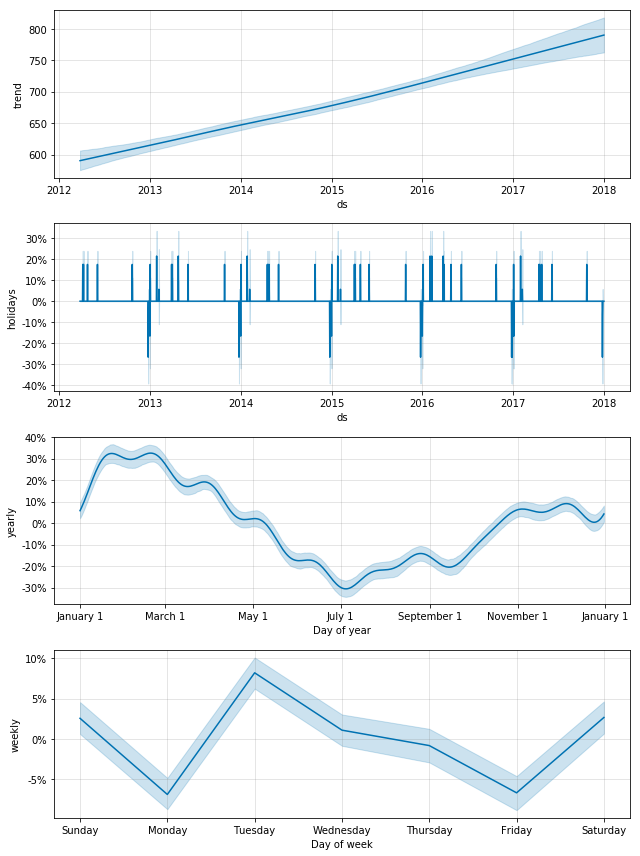

In [61]:
f = m.plot_components(forecast)

In [62]:
verif = make_verif(forecast, data_train, data_test)

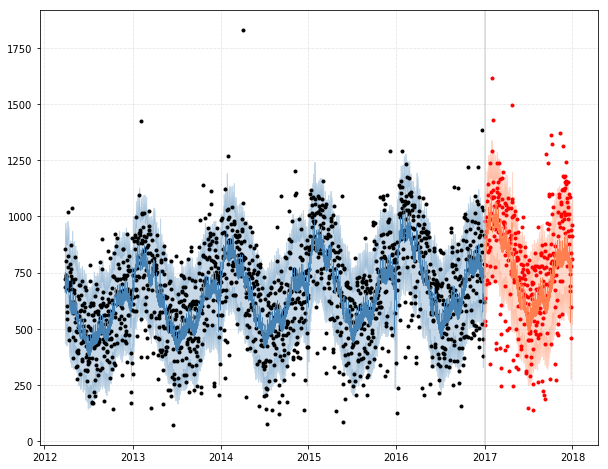

In [63]:
plot_verif(verif)

In [64]:
verif.loc[:,['y','yhat']].corr()

In [65]:
verif.loc['2017':,['y','yhat']].corr()

In [66]:
MAE(verif.y.values, verif.yhat.values)

141.97523575411725

### incorporating the effects of weather conditions

In [67]:
temp = pd.read_excel('../data/weather/Mangere_EWS.xlsx', sheet_name='temp', index_col=0, parse_dates=True)
rain = pd.read_excel('../data/weather/Mangere_EWS.xlsx', sheet_name='rain', index_col=0, parse_dates=True)
sun = pd.read_excel('../data/weather/Mangere_EWS.xlsx', sheet_name='sun', index_col=0, parse_dates=True)

In [68]:
temp = temp.interpolate(method='linear')
rain = rain.interpolate(method='linear')
sun = sun.interpolate(method='linear')

In [69]:
temp = temp.interpolate(method='linear')

In [70]:
rain = rain.interpolate(method='linear')

In [71]:
sun = sun.interpolate(method='linear')

In [72]:
data_with_regressors = add_regressor(data, temp, varname='temp')

In [73]:
data_with_regressors = add_regressor(data_with_regressors, rain, varname='rain')

In [74]:
data_with_regressors = add_regressor(data_with_regressors, sun, varname='sun')

In [75]:
data_with_regressors.head()

In [76]:
data_with_regressors.tail()

In [77]:
data_train, data_test = prepare_data(data_with_regressors, 2017)

In [78]:
m = Prophet(mcmc_samples=300, holidays=holidays, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [79]:
m.add_regressor('temp', prior_scale=0.5, mode='multiplicative')
m.add_regressor('rain', prior_scale=0.5, mode='multiplicative')
m.add_regressor('sun', prior_scale=0.5, mode='multiplicative')

In [80]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


In [81]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [82]:
futures = add_regressor_to_future(future, [temp, rain, sun])

In [83]:
forecast = m.predict(futures)

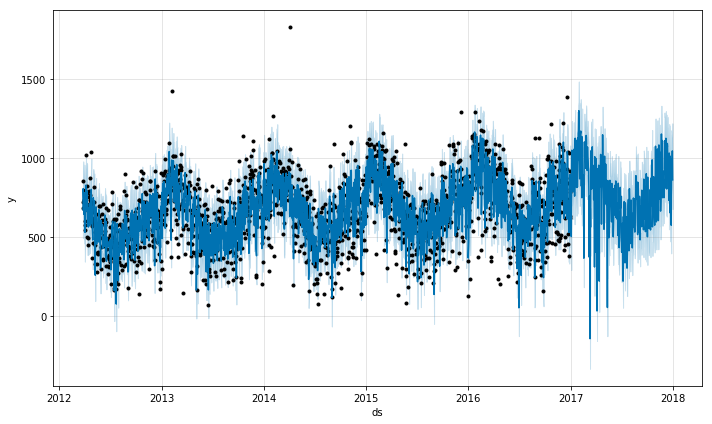

In [84]:
f = m.plot(forecast)

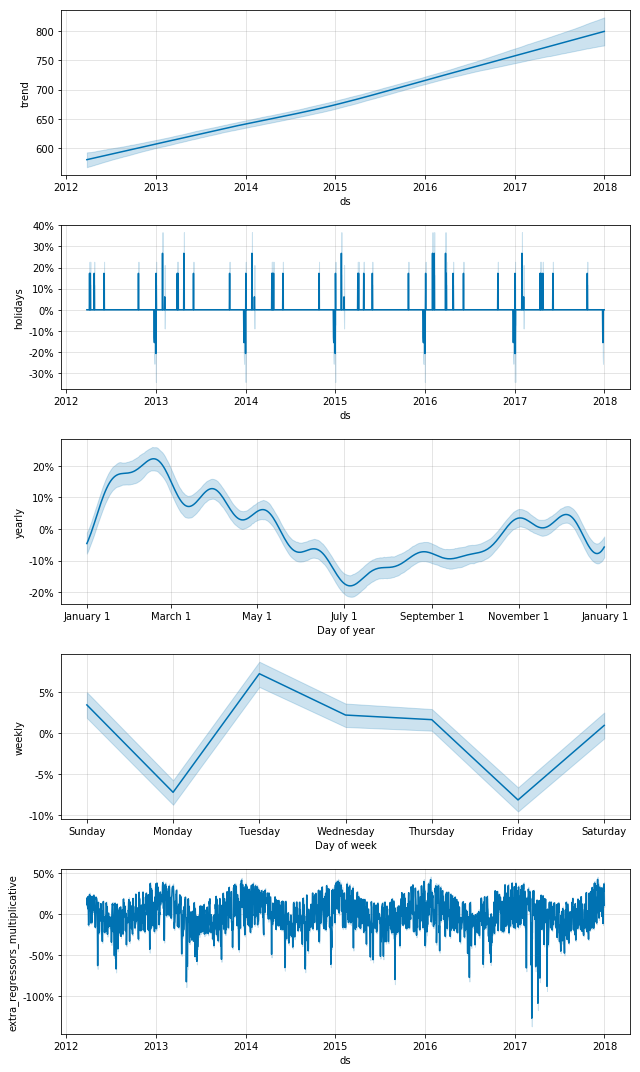

In [85]:
f = m.plot_components(forecast)

In [86]:
verif = make_verif(forecast, data_train, data_test)

In [87]:
verif.head()

In [88]:
verif.loc[:,'yhat'] = verif.yhat.clip_lower(0)

In [89]:
verif.loc[:,'yhat_lower'] = verif.yhat_lower.clip_lower(0)

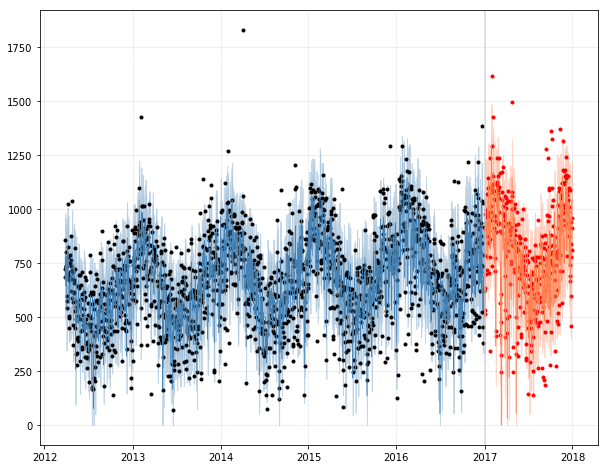

In [90]:
plot_verif(verif)

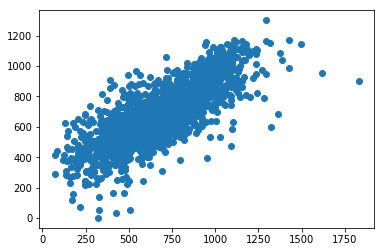

In [91]:
plt.scatter(verif.y, verif.yhat)

In [92]:
verif.loc[:,['y','yhat']].corr()

In [93]:
verif.loc['2017':,['y','yhat']].corr()

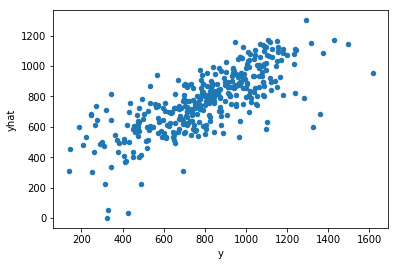

In [94]:
verif.loc['2017':].plot.scatter(x='y',y='yhat')

In [95]:
MAE(verif.y.values, verif.yhat.values)

104.84500689172695